In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import time
from numba import autojit

使用numpy包进行计算，使用matplotlib.pyplot包画图，使用copy包进行深度复制，使用time包计算运行时间，使用autojit加快计算速度。
好像autojit会在第二次运行的时候才加快速度，所以下面50个点的计算，多运行几次后会加速到正常速度。


In [2]:
#计算两点距离
@autojit(nopython=True)
def PDistance(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2+(y1-y2)**2)

#计算T0
@autojit(nopython=True)
def PT0(points,path):
    dist1 = 0
    dist2 = 0
    dif = 0
    for i in range(100):  
        path1 = np.random.permutation(path)
        path2 = np.random.permutation(path)
        dist1 = PLength(points,path1,0,0)
        dist2 = PLength(points,path2,0,0)
        difNew = abs(dist1-dist2)
        if difNew >= dif:
            dif = difNew
    Pr = 0.5 
    T0 = dif / Pr
    print('T0',T0)
    return T0

#将path转个圈，使得start<end，若start>end，则将新start转为0
def Pchange(path,start,end):
    Newpath = np.arange(len(path))
    if start > end:
        Newpath[0:len(path)-start] = path[start:len(path)]
        Newpath[len(path)-start:len(path)] = path[0:start]
        Newstart = 0
        Newend = len(path) - start + end
    else:
        Newpath = path
        Newstart = start
        Newend = end
    return Newpath,Newstart,Newend

#计算从第start个点到第end个点沿path路径的长度，若start==end，则视为一整圈。无需start<end
@autojit(nopython=True)
def PLength(points,path,start,end):
    if start < 0:
        start = start + len(path)
    if end >= len(path):
        end = end - len(path)
    Plen = 0
    if start == end:
        for i in range(len(path)):
            if i == len(path)-1:
                Plen += PDistance(points[path[len(path)-1]][0],points[path[len(path)-1]][1],points[path[0]][0],points[path[0]][1])
            else:
                Plen += PDistance(points[path[i]][0],points[path[i]][1],points[path[i+1]][0],points[path[i+1]][1])
    elif start < end:
        for i in range(start,end):
            Plen += PDistance(points[path[i]][0],points[path[i]][1],points[path[i+1]][0],points[path[i+1]][1])
    else:
        Plen += PDistance(points[path[0]][0],points[path[0]][1],points[path[len(path)-1]][0],points[path[len(path)-1]][1])
        for i in range(start,len(path)-1):
            Plen += PDistance(points[path[i]][0],points[path[i]][1],points[path[i+1]][0],points[path[i+1]][1])
        for i in range(0,end):
            Plen += PDistance(points[path[i]][0],points[path[i]][1],points[path[i+1]][0],points[path[i+1]][1])
    return Plen

#画出TSP图形
def Pplot(points,path):
    Plotpoints = np.zeros((len(path) + 1,2))
    for i in range(len(path)):
        Plotpoints[i,0] = points[path[i]][0]
        Plotpoints[i,1] = points[path[i]][1]
    Plotpoints[len(path),0] = points[path[0]][0]
    Plotpoints[len(path),1] = points[path[0]][1]
    plt.plot(Plotpoints[:,0],Plotpoints[:,1])

#后面的函数使用之前先Pchange,使得s<t
#将下标s到t之间的路径反转
def inverse(path,s,t):
    if s == 0:
        path[s:t+1] = path[t::-1]
    else:
        path[s:t+1] = path[t:s-1:-1]  

#将下标s的点插入到下标t的点后面，并将s-1与s+1相连
def insert(path,s,t):
    if s!=t:
        idx=path[s]
        path[s:t] = path[s+1:t+1]
        path[t] = idx

#交换下标s与t的两点。
def swap(path,s,t):
    idx = path[s]
    path[s] = path[t]
    path[t] = idx

Pdistance计算两点距离，PT0计算初始温度，Pchange将path转圈，使得$s<t$，PLength计算按此路程两点间的距离，Pplot画出TSP图形，inverse、insert、swap可以逆序、插入、交换两节点。

In [3]:
#TSP问题主算法
def TSP(points,path,Lk,T0,Tmin,Ttimes):
    T = T0
    N = len(path)
    length = PLength(points,path,0,0)
    print('First length',length)
    time = 0
    lengthplt = np.zeros(Ttimes) #计算每一步运算的路程长度
    while T >= Tmin: #降温循环
        for i in range(int(Lk * np.log(1+1/T))): #恒温循环
            s = 0
            t = 0
            while s == t:
                s = np.random.randint(0,len(path))
                t = np.random.randint(0,len(path))
            path,s,t = Pchange(path,s,t) 
             #仅考虑s-1==t的情况，由于这种情况s都会被Pchange函数转为0，所以只需要考虑s==0，此时s-1>t+1，导致计算出错
            if s == 0 and t == len(path) - 1:
                dist = PLength(points,path,len(path)-2,1)
                path3 = copy.deepcopy(path)
                swap(path3,s,t) #此时inverse、insert、swap结果相同，故只需要计算一种
                dist3 = PLength(points,path3,len(path)-2,1)
                if dist3 <= dist:
                    length = length - dist + dist3
                    path = path3
                else:
                    p = np.exp(-(dist3-dist)/T)
                    r = np.random.uniform(low = 0,high = 1)
                    if r < p:
                        length = length - dist + dist3
                        path = path3
            else:
                #使用deepcopy，将数组数值而非指针复制到新数组中
                path1 = copy.deepcopy(path)
                path2 = copy.deepcopy(path)
                path3 = copy.deepcopy(path)
                dist = PLength(points,path,s-1,s+1) + PLength(points,path,t-1,t+1)
                inverse(path1,s,t)
                dist1 = PLength(points,path1,s-1,s+1) + PLength(points,path1,t-1,t+1)
                insert(path2,s,t)
                dist2 = PLength(points,path2,s-1,s) + PLength(points,path2,t-1,t+1) + PLength(points,path,t-1,t)
                swap(path3,s,t)
                dist3 = PLength(points,path3,s-1,s+1) + PLength(points,path3,t-1,t+1)
                '''
                #使用softmax方法随机选取，但是计算量太大，效果不好
                p1 = dist1 / dist
                p2 = dist2 / dist
                p3 = dist3 / dist
                minp = min(p1,p2,p3)*0.8
                p1 = np.exp(1/(p1-minp))
                p2 = np.exp(1/(p2-minp))
                p3 = np.exp(1/(p3-minp))
                #print(p1,p2,p3)            
                p = np.random.uniform(low=0,high=1)
                '''
                #找出新dist中最小的那个，并继续模拟退火方法
                if dist1 <= dist2 and dist1 <= dist3:
                    if dist1 <= dist:
                        length = length - dist + dist1
                        path = path1
                    else:
                        p = np.exp(-(dist1-dist)/T)
                        r = np.random.uniform(low = 0,high = 1)
                        if r < p:
                            length = length - dist + dist1
                            path = path1
                elif dist2 < dist1 and dist2 <= dist3:
                    if dist2 <= dist:
                        length = length - dist + dist2
                        path = path2
                    else:
                        p = np.exp(-(dist2-dist)/T)
                        r = np.random.uniform(low = 0,high = 1)
                        if r < p:
                            length = length - dist + dist2
                            path = path2
                else:
                    if dist3 <= dist:
                        length = length - dist + dist3
                        path = path3
                    else:
                        p = np.exp(-(dist3-dist)/T)
                        r = np.random.uniform(low = 0,high = 1)
                        if r < p:
                            length = length - dist + dist3
                            path = path3
        #以pback的概率升温一倍
        pback = np.random.uniform(low = 0,high = 1)
        if pback < 0.15:
            T = T * 2
            continue
        lengthplt[time] = length
        time += 1
        #显示当前完成进度比，10%一档
        if time % (T0/(Tmin*10)) < 1:
            print(round(time/(T0/Tmin)*100,1),'%')
        '''
        l=PLength(points,path,3,3)
        print(time,length,l)
        '''
        T = T0 / (1 + time)
    print('Final length',length)
    return path,lengthplt

TSP算法主程序如上，下面首先以线性函数设置降温次数Ttimes，实现TSP问题

In [4]:
N = 50
begintime = time.clock()
print('Number of points',N)
points = np.random.rand(N,2)
path = np.arange(N)
T0 = PT0(points,path)
Ttimes = 20 * N
Tmin = T0 / Ttimes
finalpath,lengthplt = TSP(points,path,15,T0,Tmin,int(Ttimes))
endtime = time.clock()
print('Time',endtime - begintime,'s')

Number of points 50
T0 9.86055713661466
First length 25.758572887983288
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
Final length 5.912778165694818
Time 2.8918027377777777 s


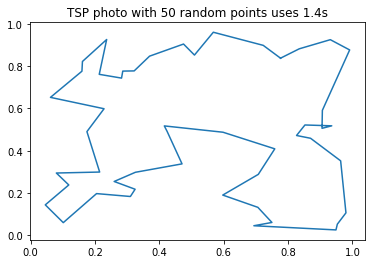

In [169]:
Pplot(points,finalpath)
plt.title('TSP photo with '+str(N)+' random points uses '+str(round(endtime - begintime,1))+'s')
plt.show()

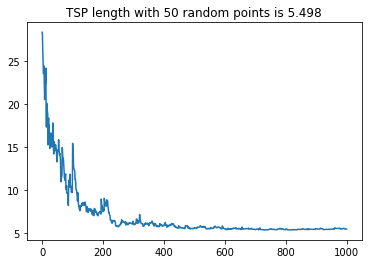

In [170]:
plt.plot(np.arange(len(lengthplt)),lengthplt)
plt.title('TSP length with '+str(N)+' random points is '+str(round(lengthplt[len(lengthplt)-1],4)))
plt.show()

50个点计算很快，第一张图为TSP路径，第二张图为每一歩的距离。下面给出已知TSP最优解的作图，是按顺序的正方形，从$(0,1)$向右画正方形然后回到起点。

In [138]:
#形成正方形格点图
def Spoints(N):
    num = int(N / 4)
    points = np.zeros((N,2))
    for i in range(num):
        points[i,0] = i*(1/num)
        points[i,1] = 1
    for i in range(num,2*num):
        points[i,0] = 1
        points[i,1] = (2*num-i) *(1/num)
    for i in range(2*num,3*num):
        points[i,0] = (3*num-i)*(1/num)
        points[i,1] = 0
    for i in range(3*num,N):
        points[i,0] = 0
        points[i,1] = (i-3*num)*(1/(N-3*num))
    return points

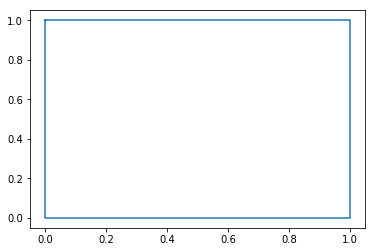

In [139]:
points = Spoints(100)
Pplot(points,np.arange(100))

在正方形节点下，计算平均误差小于$1%$时的降温次数，$N=10,20,…,100$，$N=10$时算的挺快的，所以可以运行一下。

In [174]:
N = 10
for i in range(1,11):
    avepath = 0
    for j in range(10):
        print('Number of i',i)
        print('Number of j',j)
        print('Number of points',N)
        points = Spoints(N)
        path = np.random.permutation(np.arange(N))
        T0 = PT0(points,path)
        Ttimes = N * 4 * i
        Tmin = T0 / Ttimes
        finalpath,lengthplt = TSP(points,path,15,T0,Tmin,Ttimes)
        avepath += PLength(points,finalpath,0,0)
    if avepath / 10 < 4 * 1.01:
        print('Best number',i)
        break

Number of i 1
Number of j 0
Number of points 10
T0 6.942830693313741
First length 8.80090714511837
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
Final length 4.309016994374943
Number of i 1
Number of j 1
Number of points 10
T0 6.274888238242276
First length 7.329147733088901
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
Final length 5.70782738952927
Number of i 1
Number of j 2
Number of points 10
T0 7.373843449597471
First length 9.074377521164521
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
Final length 3.9999999999999956
Number of i 1
Number of j 3
Number of points 10
T0 8.59380036393182
First length 8.325861378279154
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
Final length 4.309016994374949
Number of i 1
Number of j 4
Number of points 10
T0 6.788057011970565
First length 9.325861378279154
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
100.0 %
Final length 4.30901699

由上面可以得到Best number，比如$N=10$时，$i=2$，$Ttimes=N*4*i$，所以$N=10$对应的$M=80$。

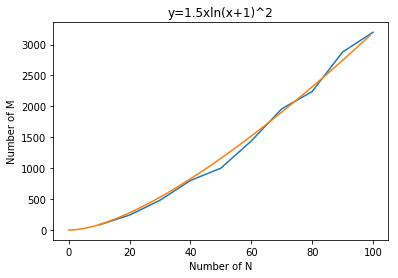

In [141]:
numN = [10,20,30,40,50,60,70,80,90,100]
numTime = [80,240,480,800,1000,1440,1960,2240,2880,3200]
plt.plot(numN,numTime)
x = np.arange(100)
y = np.arange(100)
a = 1.5
for i in range(100):
    y[i] = a*i*np.log(i+1)**2
plt.plot(x,y)
plt.title('y=1.5xln(x+1)^2')
plt.xlabel('Number of N')
plt.ylabel('Number of M')
plt.show()

描点画图，手工拟合。下面的运行超级慢，需要超过1小时时间，所以我加了'''，这是为了画出报告里图2、图3的图。验证理论的时间复杂度是否正确，并且得到在$N$个随机点下TSP问题的最优值的函数。

In [17]:
'''
i = 0
K = 320
wholetime = np.zeros(K-5)
wholelength = np.zeros(K-5)
for N in range(5,K):
    print('Number of points',N)
    begintime = time.clock()
    points = np.random.rand(N,2)
    path = np.arange(N)
    T0 = PT0(points,path)
    Ttimes = 1.5 * N * np.log(N) ** 2
    Tmin = T0 / Ttimes
    finalpath,lengthplt = TSP(points,path,15,T0,Tmin,Ttimes)
    endtime = time.clock()
    wholetime[i] = endtime-begintime
    wholelength[i] = PLength(points,finalpath,0,0)
    i=i+1
'''

Number of points 5
T0 1.6907780365898368
First length 2.046128206661293
10.3 %
20.6 %
30.9 %
41.2 %
51.5 %
61.8 %
72.1 %
82.4 %
92.7 %
Final length 2.158050379545917
Number of points 6
T0 2.43720472478043
First length 2.8938048560905902
10.4 %
20.8 %
31.1 %
41.5 %
51.9 %
62.3 %
72.7 %
83.1 %
93.4 %
Final length 2.1183092795134133
Number of points 7
T0 4.5629775320111525
First length 4.307354815617959
10.1 %
20.1 %
30.2 %
40.2 %
50.3 %
60.4 %
70.4 %
80.5 %
90.5 %
Final length 2.5597838435442988
Number of points 8
T0 4.77804598274839
First length 5.006645296579105
11.6 %
21.2 %
30.8 %
40.5 %
50.1 %
61.7 %
71.3 %
80.9 %
90.6 %
Final length 3.044740472217164
Number of points 9
T0 4.602877298721026
First length 4.943536832502753
10.7 %
21.5 %
30.7 %
41.4 %
50.6 %
61.4 %
70.6 %
81.3 %
90.5 %
Final length 4.070124585453936
Number of points 10
T0 4.400640400225533
First length 4.951543198232759
10.1 %
20.1 %
30.2 %
40.2 %
50.3 %
60.4 %
70.4 %
80.5 %
90.5 %
Final length 2.6820802878861683
Numbe

20.0 %
30.0 %
40.0 %
50.0 %
60.1 %
70.1 %
80.1 %
90.0 %
Final length 6.468777649996266
Number of points 55
T0 10.672491668643005
First length 31.022081032685772
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 6.361589043226946
Number of points 56
T0 10.51412873326506
First length 28.80107674940791
10.1 %
20.1 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 5.733028134128648
Number of points 57
T0 13.81120861006029
First length 33.042148099115295
10.0 %
20.0 %
30.1 %
40.1 %
50.0 %
60.0 %
70.0 %
80.1 %
90.0 %
Final length 6.660398821064902
Number of points 58
T0 12.25997203649095
First length 31.413704568634593
10.0 %
20.0 %
30.0 %
40.0 %
50.1 %
60.0 %
70.1 %
80.0 %
90.0 %
Final length 6.541546728488551
Number of points 59
T0 10.554587199958078
First length 31.245036528270898
10.1 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.1 %
80.1 %
90.0 %
Final length 6.223785694139563
Number of points 60
T0 10.678178094717573
First length 32.68692881354888
10.0

40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 8.47938634428646
Number of points 104
T0 14.187852442877528
First length 56.627724603669776
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 7.728589621222191
Number of points 105
T0 18.608330984762517
First length 57.67462339848201
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 8.451543824505322
Number of points 106
T0 16.266976534897296
First length 57.439172407516075
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 8.415690936894249
Number of points 107
T0 17.2584367814421
First length 55.22996993058574
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 8.637803773285498
Number of points 108
T0 14.691977935824639
First length 54.63649178572303
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 8.629667548207332
Number of points 109
T0 19.1797481695494
First length 55.49602204561496
10.0 %
20.0 %
30

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 10.11969583789583
Number of points 153
T0 23.134171239177533
First length 79.34766836088278
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 9.985941935532615
Number of points 154
T0 20.668796372308947
First length 79.06235141616698
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 10.178897842858904
Number of points 155
T0 20.440195489452577
First length 78.79754509244489
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 9.85489326447724
Number of points 156
T0 17.424321535569618
First length 83.41607454798726
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 9.777763632649588
Number of points 157
T0 24.08801461337697
First length 81.37370366455298
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 9.711856513527172
Number of points 158
T0 20.54529731531821
First length 81.000976090

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 11.210405212197335
Number of points 202
T0 24.71384908329378
First length 100.6130558079977
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 11.366777731629098
Number of points 203
T0 21.147655380703412
First length 104.31587451876466
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 11.779835823237946
Number of points 204
T0 17.141140454431536
First length 109.87732055799519
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 11.501329029335686
Number of points 205
T0 22.57749737216659
First length 102.654178286917
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 11.228962790613707
Number of points 206
T0 21.61669813963104
First length 106.57759067765693
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 11.344656330406785
Number of points 207
T0 19.005447759399345
First length 105.7

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 12.14775970224408
Number of points 251
T0 24.547509295226007
First length 130.4225273344829
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 12.19688367373012
Number of points 252
T0 27.88980702797116
First length 128.7732143651997
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 12.255154806687763
Number of points 253
T0 25.277664082406943
First length 131.21864270784354
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 12.597598728731061
Number of points 254
T0 24.15570635538768
First length 126.14992001404364
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 12.15916320264671
Number of points 255
T0 28.11029758640069
First length 133.7494071838148
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 12.325084094068986
Number of points 256
T0 27.931705433588064
First length 136.5685

10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 13.159409109933126
Number of points 300
T0 29.720453987102474
First length 159.2471353931499
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 13.475388632049976
Number of points 301
T0 41.495656684801475
First length 157.4719361990438
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 13.280220751104958
Number of points 302
T0 25.161004967185363
First length 154.85200060326932
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 13.350495208976636
Number of points 303
T0 32.411106641413994
First length 162.4001774035739
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 13.723938273658097
Number of points 304
T0 34.04928311641032
First length 160.27093865475297
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 13.3139145147571
Number of points 305
T0 31.720416135045923
First length 153.4

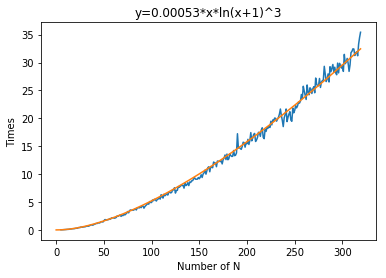

In [142]:
'''
plt.plot(np.arange(5,K),wholetime)
x = np.arange(320)
y = np.zeros(320)
a = 0.00053
for i in range(320):
    y[i] = a*i*np.log(i+1)**3
plt.plot(x,y)
plt.title('y=0.00053*x*ln(x+1)^3')
plt.xlabel('Number of N')
plt.ylabel('Times')
plt.show()
'''

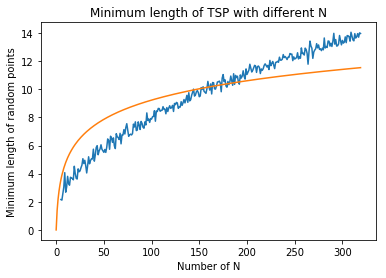

In [143]:
'''
plt.plot(np.arange(5,K),wholelength)
x = np.arange(320)
y = np.zeros(320)
a = 2
for i in range(320):
    y[i] = a*np.log(i+1)
plt.plot(x,y)
plt.title('Minimum length of TSP with different N')
plt.xlabel('Number of N')
plt.ylabel('Minimum length of random points')
plt.show()
'''

上面图片的分析都在报告中了，下面的内容就是所有都修改好的算法，以200个点为例。

In [171]:
N = 200
begintime = time.clock()
print('Number of points',N)
points = np.random.rand(N,2)
path = np.arange(N)
T0 = PT0(points,path)
Ttimes = 1.5 * N * np.log(N) ** 2
Tmin = T0 / Ttimes
finalpath,lengthplt = TSP(points,path,15,T0,Tmin,int(Ttimes))
endtime = time.clock()
print('Time',endtime - begintime,'s')

Number of points 200
T0 23.54850180128696
First length 107.29795444838841
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 10.96657414119709
Time 15.888341523899726 s


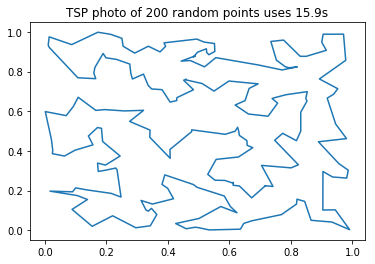

In [172]:
Pplot(points,finalpath)
plt.title('TSP photo of '+str(N)+' random points uses '+str(round(endtime - begintime,1))+'s')
plt.show()

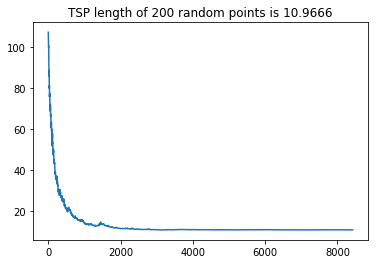

In [173]:
plt.plot(np.arange(len(lengthplt)),lengthplt)
plt.title('TSP length of '+str(N)+' random points is '+str(round(lengthplt[len(lengthplt)-1],4)))
plt.show()

200个点的还是能少算很多次得到差不多最优值的，增大允许误差可以加快很多速度。下面尝试计算运算上限，使用2000个点为例子。大概运算10分钟，慎运行。

In [6]:
N = 5000
begintime = time.clock()
print('Number of points',N)
points = np.random.rand(N,2)
path = np.arange(N)
T0 = PT0(points,path)
Ttimes = 1.5 * N * np.log(N) ** 2
Tmin = T0 / Ttimes
finalpath,lengthplt = TSP(points,path,15,T0,Tmin,int(Ttimes))
endtime = time.clock()
print('Time',endtime - begintime,'s')

Number of points 5000
T0 103.7468361239089
First length 2596.123496240324
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Final length 56.1284146338184
Time 2446.3755432530243 s


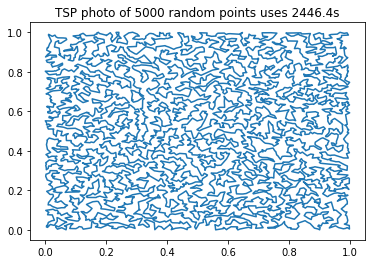

In [7]:
Pplot(points,finalpath)
plt.title('TSP photo of '+str(N)+' random points uses '+str(round(endtime - begintime,1))+'s')
plt.show()

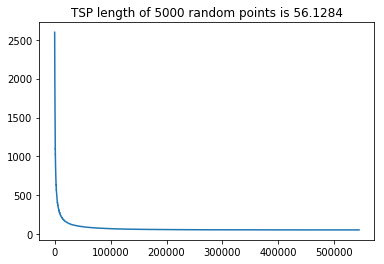

In [8]:
plt.plot(np.arange(len(lengthplt)),lengthplt)
plt.title('TSP length of '+str(N)+' random points is '+str(round(lengthplt[len(lengthplt)-1],4)))
plt.show()

2000个点也能很好的计算出结果，使用1/5的计算量可能就够了。应该是多少个点都能计算，只是时间问题。
本机配置
CPU Core(TM) i7-7700 CPU @ 3.60GHz(3600 MHz)
显卡 NVIDIA GeForce GTX 1060 6GB (6144MB)
内存 16.00 GB (2400 MHz)